In [1]:
!wget https://dl.fbaipublicfiles.com/glue/data/QQP-clean.zip
!unzip QQP-clean.zip

--2022-11-14 05:34:56--  https://dl.fbaipublicfiles.com/glue/data/QQP-clean.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 104.22.74.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41696084 (40M) [application/zip]
Saving to: ‘QQP-clean.zip’

QQP-clean.zip       100%[===================>]  39.76M  4.92MB/s    in 8.2s    

2022-11-14 05:35:06 (4.87 MB/s) - ‘QQP-clean.zip’ saved [41696084/41696084]

Archive:  QQP-clean.zip
   creating: QQP/
  inflating: QQP/train.tsv           
  inflating: QQP/dev.tsv             
  inflating: QQP/test.tsv            


In [2]:
!pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 5.4 MB/s 
     |████████████████████████████████| 5.5 MB 57.0 MB/s 
     |████████████████████████████████| 1.3 MB 57.9 MB/s 
     |████████████████████████████████| 163 kB 71.5 MB/s 
     |████████████████████████████████| 7.6 MB 58.0 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=a07b1e16a0c035cb248158eaa69b76aef380bb2299cd535eff30ddf5eb6ef803
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers


In [3]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

import random, os
import numpy as np
import pandas as pd
from pprint import pprint

from sentence_transformers import SentenceTransformer, util
from torchinfo import summary

In [5]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# seed_everything()    

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print (device)

cuda:0


In [7]:
TRAIN_PATH = "QQP/train.tsv"
VAL_PATH = "QQP/dev.tsv"
TEST_PATH = "QQP/test.tsv"

In [8]:
train_df = pd.read_csv(TRAIN_PATH, delimiter="\t")
val_df = pd.read_csv(VAL_PATH, delimiter="\t")
test_df = pd.read_csv(TEST_PATH, delimiter="\t")

In [9]:
pprint (train_df.columns)

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object')


In [10]:
print (train_df.isnull().sum())
train_df = train_df.dropna()
test_df = test_df.dropna()
val_df = val_df.dropna()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64


In [11]:
N_samples = "FULL" # "FULL" or some integer

if N_samples == "FULL":
    train_corpus1 = train_df['question1'].to_list()
    train_corpus2 = train_df['question2'].to_list()
    train_labels = train_df['is_duplicate'].to_list()
else:
    assert isinstance(N_samples, int), "N_samples is not integer"

    train_corpus1 = train_df['question1'].to_list()[:N_samples]
    train_corpus2 = train_df['question2'].to_list()[:N_samples]
    train_labels = train_df['is_duplicate'].to_list()[:N_samples]

val_corpus1 = val_df['question1'].to_list()
val_corpus2 = val_df['question2'].to_list()
val_labels = val_df['is_duplicate'].to_list()

In [12]:
test_corpus1 = test_df['question1'].to_list()
test_corpus2 = test_df['question2'].to_list()
# test_labels = test_df['is_duplicate'].to_list()

QN1, QN2, Label

In [13]:
class Dataset_seq(torch.utils.data.Dataset):
    def __init__(self, questions1, questions2, labels):
        # read the data and label 
        self.qn1, self.qn2, self.labels = questions1, questions2, labels
        self.model = SentenceTransformer('all-MiniLM-L6-v2').to(torch.device("cuda:0"))
        self.emb1, self.emb2 = self.preprocess(questions1, questions2)

    def __getitem__(self, index):
        # return the seq and label 
        emb1 = self.emb1[index]
        emb2 = self.emb2[index]
        label = torch.tensor(self.labels[index]).float()

        return emb1, emb2, label

    def __len__(self):
        return(len(self.labels))

    def preprocess(self, corpus1, corpus2):
        # used to convert line into tokens and then into their corresponding numericals values using word2id
        embeddings1 = self.model.encode(corpus1, convert_to_tensor=True)
        embeddings2 = self.model.encode(corpus2, convert_to_tensor=True)

        N1, d1 = embeddings1.shape
        N2, d2 = embeddings2.shape

        embeddings1 = embeddings1.view(N1, 1, d1)
        embeddings2 = embeddings2.view(N2, 1, d2)

        return embeddings1, embeddings2

In [14]:
train_dataset = Dataset_seq(train_corpus1, train_corpus2, train_labels) # takes about 4-5 mins to run
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=256, shuffle=True)

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [15]:
val_dataset = Dataset_seq(val_corpus1, val_corpus2, val_labels) # takes <1 min to run
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=256)

In [16]:
class LSTM(nn.Module):
    def __init__(self, in_dim, hidden_dim, proj_dim, fc_dim=256, num_layers=5):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.proj_dim = proj_dim

        self.lstm = nn.LSTM(input_size=in_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, fc_dim)
        self.project = nn.Linear(fc_dim, proj_dim)

    def forward(self, x):
        B, T, d = x.shape
        h_0 = torch.autograd.Variable(torch.zeros(self.num_layers, B, self.hidden_dim)).to(x.device) # hidden state
        c_0 = torch.autograd.Variable(torch.zeros(self.num_layers, B, self.hidden_dim)).to(x.device)

        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # lstm forward pass
        hn = hn.mean(0).view(-1, self.hidden_dim) # average across layer dimension
        
        out = torch.relu(hn)
        out = self.fc1(out) #first Dense
        out = torch.relu(out) #relu
        out = self.project(out) #Final Output

        return out

In [17]:
class LSTMClassifier(nn.Module):
    def __init__(self, in_dim, lstm_hidden_dim, proj_dim, h1=128, h2=64, out_dim=1):
        super().__init__()
        self.lstm = LSTM(in_dim, lstm_hidden_dim, proj_dim)

        self.net = nn.Sequential(
                        nn.Linear(2 * proj_dim, h1),
                        nn.ReLU(),
                        nn.Linear(h1, h2),
                        nn.ReLU(),
                        nn.Linear(h2, out_dim)
                    )

    def forward(self, x1, x2, add_ftrs=None, contrastive=False):
        # B, T, d = x.shape
        hn1 = self.lstm(x1)
        hn2 = self.lstm(x2)
        
        x_cat = torch.cat([hn1, hn2], dim=1)
        assert x_cat.size(1) == hn1.size(1) * 2 == hn2.size(1) * 2
        
        x_cat = torch.relu(x_cat)
        out = self.net(x_cat)

        if contrastive:
            return out, hn1, hn2

        return out

In [18]:
def get_accuracy(y_true, y_prob):
    assert y_true.ndim == 1 and y_true.size() == y_prob.size()
    y_prob = y_prob > 0.5
    # return (y_true == y_prob).sum().item() / y_true.size(0)
    return (y_true == y_prob).sum().item()

def evaluate_model(model, loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            q1, q2, y = data
            q1, q2, y = q1.to(torch.device("cpu")), q2.to(torch.device("cpu")), y.to(torch.device("cpu"))
            q1, q2, y = q1.to(torch.device("cuda:0")), q2.to(torch.device("cuda:0")), y.to(torch.device("cuda:0"))
            
            outputs = model(q1, q2)
            outputs = outputs.view(-1)
            y = y.view(-1)

            batch_acc = get_accuracy(y, outputs)
            batch_size = y.size(0)

            correct += batch_acc
            total += batch_size

    return correct / total

In [19]:
# instantiate model
model = LSTMClassifier(in_dim=384, lstm_hidden_dim=256, proj_dim=128).to(torch.device("cuda:0"))
optimiser = torch.optim.AdamW(model.parameters())
sl_loss_fn = nn.BCEWithLogitsLoss()

# training loop
EPOCHS = 50

sl_losses = []
sl_accs_train = []
sl_accs_test = []

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    for b_idx, batch in enumerate(train_loader):
        optimiser.zero_grad()
        
        q1, q2, y = batch
        q1, q2, y = q1.to(torch.device("cpu")), q2.to(torch.device("cpu")), y.to(torch.device("cpu"))
        q1, q2, y = q1.to(torch.device("cuda:0")), q2.to(torch.device("cuda:0")), y.to(torch.device("cuda:0"))
        
        pred = model(q1, q2)
        loss = sl_loss_fn(pred.view(-1), y)
        
        loss.backward()
        optimiser.step()

        epoch_loss += loss.detach().item()

    epoch_loss = epoch_loss / len(train_loader)
    sl_losses.append(epoch_loss)

    model.eval()
    train_accuracy = evaluate_model(model, train_loader)
    test_accuracy = evaluate_model(model, val_loader)

    sl_accs_train.append(train_accuracy)
    sl_accs_test.append(test_accuracy)

    if epoch % 5 == 0:
        print (f"Epoch loss: {epoch_loss:.10f} | Train Accuracy: {train_accuracy:.4f} | Val Accuracy: {test_accuracy:.4f}")

Epoch loss: 0.5324272451 | Train Accuracy: 0.7292 | Val Accuracy: 0.7271
Epoch loss: 0.3847730109 | Train Accuracy: 0.8189 | Val Accuracy: 0.8005
Epoch loss: 0.3188487528 | Train Accuracy: 0.8589 | Val Accuracy: 0.8179
Epoch loss: 0.2552399515 | Train Accuracy: 0.9056 | Val Accuracy: 0.8283
Epoch loss: 0.1965796763 | Train Accuracy: 0.9327 | Val Accuracy: 0.8392
Epoch loss: 0.1519155245 | Train Accuracy: 0.9555 | Val Accuracy: 0.8408
Epoch loss: 0.1207872687 | Train Accuracy: 0.9661 | Val Accuracy: 0.8437
Epoch loss: 0.0986161682 | Train Accuracy: 0.9716 | Val Accuracy: 0.8430
Epoch loss: 0.0848239561 | Train Accuracy: 0.9774 | Val Accuracy: 0.8431
Epoch loss: 0.0735555356 | Train Accuracy: 0.9806 | Val Accuracy: 0.8428


In [20]:
print ("Max Train Accuracy for LSTM-SL:", max(sl_accs_train))
print ("Max Val Accuracy for LSTM-SL:", max(sl_accs_test))

Max Train Accuracy for LSTM-SL: 0.9826877305233533
Max Val Accuracy for LSTM-SL: 0.846895869403908


In [21]:
!pip install pytorch_metric_learning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 111 kB 30.0 MB/s 


In [22]:
from pytorch_metric_learning import losses

# Self-supervised Learning

Make the appropriate changes as shown in the Google Sheets.

In [23]:
# instantiate model
model2 = LSTMClassifier(in_dim=384, lstm_hidden_dim=256, proj_dim=128).to(torch.device("cuda:0"))
optimiser2 = torch.optim.AdamW(model2.parameters())
sl_loss_fn = nn.BCEWithLogitsLoss()
ssl_loss_fn = losses.ContrastiveLoss() # do NOT use losses.NTXentLoss()

# training loop
EPOCHS = 50

sl_ssl_losses = []
sl_loss_only = []
ssl_loss_only = []
sl_ssl_accs_train = []
sl_ssl_accs_test = []

# CHANGE THESE COEFFICIENTS ACCORDINGLY
c_sl = 0.2
c_sl_ssl = 1

for epoch in range(EPOCHS):
    model2.train()
    epoch_loss = 0
    for b_idx, batch in enumerate(train_loader):
        optimiser2.zero_grad()
        
        q1, q2, y = batch
        q1, q2, y = q1.to(torch.device("cpu")), q2.to(torch.device("cpu")), y.to(torch.device("cpu"))
        q1, q2, y = q1.to(torch.device("cuda:0")), q2.to(torch.device("cuda:0")), y.to(torch.device("cuda:0"))
        
        pred, z1, z2 = model2(q1, q2, contrastive=True)
        z_cat = torch.cat([z1, z2], dim=1)

        sl_loss = sl_loss_fn(pred.view(-1), y)
        ssl_loss = ssl_loss_fn(z_cat, y)

        sl_loss_only.append(sl_loss.item())
        ssl_loss_only.append(ssl_loss.item())

        total_loss = c_sl*sl_loss + c_sl_ssl*ssl_loss
        
        total_loss.backward()
        optimiser2.step()

        epoch_loss += total_loss.detach().item()

    epoch_loss = epoch_loss / len(train_loader)
    sl_ssl_losses.append(epoch_loss)

    model2.eval()
    train_accuracy = evaluate_model(model2, train_loader)
    test_accuracy = evaluate_model(model2, val_loader)

    sl_ssl_accs_train.append(train_accuracy)
    sl_ssl_accs_test.append(test_accuracy)

    if epoch % 5 == 0:
        print (f"Epoch loss: {epoch_loss:.10f} | Train Accuracy: {train_accuracy:.4f} | Val Accuracy: {test_accuracy:.4f}")

Epoch loss: 1.1338144391 | Train Accuracy: 0.7358 | Val Accuracy: 0.7314
Epoch loss: 1.1012870791 | Train Accuracy: 0.7884 | Val Accuracy: 0.7810
Epoch loss: 1.0940899419 | Train Accuracy: 0.8119 | Val Accuracy: 0.8016
Epoch loss: 1.0895342999 | Train Accuracy: 0.8263 | Val Accuracy: 0.8122
Epoch loss: 1.0855228529 | Train Accuracy: 0.8385 | Val Accuracy: 0.8181
Epoch loss: 1.0832201814 | Train Accuracy: 0.8546 | Val Accuracy: 0.8256
Epoch loss: 1.0803750291 | Train Accuracy: 0.8605 | Val Accuracy: 0.8265
Epoch loss: 1.0793365759 | Train Accuracy: 0.8690 | Val Accuracy: 0.8276
Epoch loss: 1.0776900929 | Train Accuracy: 0.8709 | Val Accuracy: 0.8255
Epoch loss: 1.0766493196 | Train Accuracy: 0.8841 | Val Accuracy: 0.8331


In [24]:
print ("Max Train Accuracy for LSTM-SL+SSL:", max(sl_ssl_accs_train))
print ("Max Val Accuracy for LSTM-SL+SSL:", max(sl_ssl_accs_test))

Max Train Accuracy for LSTM-SL+SSL: 0.8841487882235891
Max Val Accuracy for LSTM-SL+SSL: 0.8334899826861242


In [25]:
print (len(sl_loss_only), len(ssl_loss_only))

71100 71100


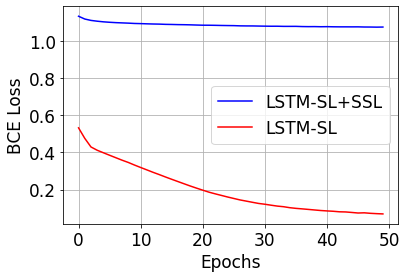

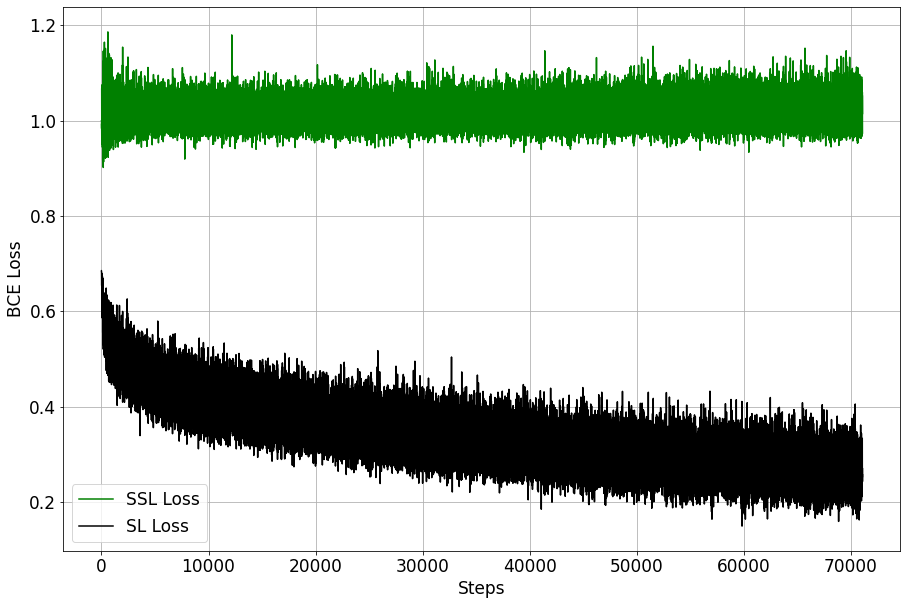

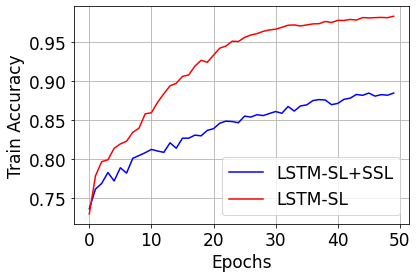

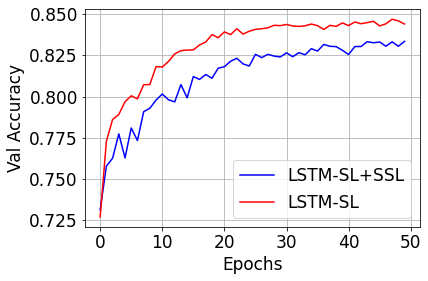

In [26]:
import matplotlib.pyplot as plt
import matplotlib

font = {'family' : 'normal',
        'size'   : 17}

matplotlib.rc('font', **font)
# matplotlib.rc('legend', **{"loc": "upper right"})

epochs = range(EPOCHS)
fig = plt.figure()
plt.plot(epochs, sl_ssl_losses, label="LSTM-SL+SSL", color="blue")
plt.plot(epochs, sl_losses, label="LSTM-SL", color="red")
plt.xlabel("Epochs")
plt.ylabel("BCE Loss")
plt.grid()
plt.legend()
plt.show()

epochs = range(EPOCHS * len(train_loader))
fig = plt.figure(figsize=(15, 10))
plt.plot(epochs, ssl_loss_only, label="SSL Loss", color="green")
plt.plot(epochs, sl_loss_only, label="SL Loss", color="black")
plt.xlabel("Steps")
plt.ylabel("BCE Loss")
plt.grid()
plt.legend()
plt.show()

epochs = range(EPOCHS)
fig = plt.figure()
plt.plot(epochs, sl_ssl_accs_train, label="LSTM-SL+SSL", color="blue")
plt.plot(epochs, sl_accs_train, label="LSTM-SL", color="red")
plt.xlabel("Epochs")
plt.ylabel("Train Accuracy")
plt.grid()
plt.legend()
plt.show()

epochs = range(EPOCHS)
fig = plt.figure()
plt.plot(epochs, sl_ssl_accs_test, label="LSTM-SL+SSL", color="blue")
plt.plot(epochs, sl_accs_test, label="LSTM-SL", color="red")
plt.xlabel("Epochs")
plt.ylabel("Val Accuracy")
plt.grid()
plt.legend()
plt.show()

In [27]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
import seaborn as sn
import pandas as pd
import numpy as np

model = model.to(torch.device("cpu"))
model2 = model2.to(torch.device("cpu"))

def get_confusion_matrix(network, test_data_loader):
    prediction = []
    actual = []

    # iterate over test data
    for i, batch in enumerate(test_data_loader):
        q1, q2, labels = batch
        q1, q2, labels = q1.to(torch.device("cpu")), q2.to(torch.device("cpu")), labels.to(torch.device("cpu")).view(-1)

        output = network(q1, q2)
        output = torch.sigmoid(output).view(-1) > 0.5
        output = output.detach().numpy().tolist()
        prediction.extend(output)

        labels = labels.tolist()
        actual.extend(labels)

    # labels = list(set(actual))
    # labels.sort()

    cf_matrix = confusion_matrix(actual, prediction)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot()
    plt.show()

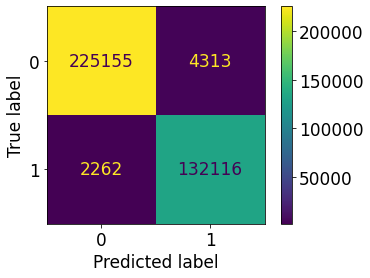

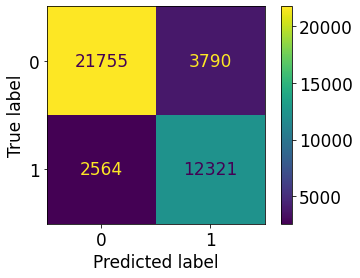

In [28]:
get_confusion_matrix(model, train_loader)
get_confusion_matrix(model, val_loader)

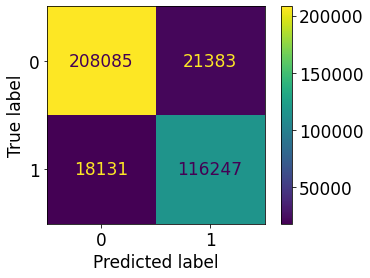

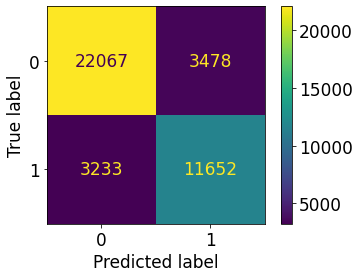

In [29]:
get_confusion_matrix(model2, train_loader)
get_confusion_matrix(model2, val_loader)